In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

import math
import os
import sys

from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

In [2]:
def _get_new_fn(fn, *args):
    fn, ext = os.path.splitext(fn)
    extra = '-'.join(args)
    return '%s-processed%s%s' % (fn, extra, ext)


def grayscale(img):
    """Applies the Grayscale transform

    This will return an image with only one color channel

    ..note::

        to see the returned image as grayscale you should call plt.imshow(gray, cmap='gray')

    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """Applies an image mask.

    Only keeps the region of the image defined by the polygon formed from `vertices`. The rest of
    the image is set to black.

    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=None, thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below

    """
    color = color or [255, 0, 0]
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def weighted_img(line_image, initial_img, α=0.8, β=1., λ=0.):
    """`line_image` is the output of the hough_lines(), An image with lines drawn on it.

    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + line_image * β + λ
    NOTE: initial_img and line_image must be the same shape!

    """
    return cv2.addWeighted(initial_img, α, line_image, β, λ)


def line_length(x1, y1, x2, y2):
    return math.sqrt((y2-y1)**2 + (x2-x1)**2)


class RightLane(object):

    def __init__(self, height, width, top_boundary):
        self.left_x = width
        self.right_x = 0
        self.lower_y = 0
        self.upper_y = height

        self._top_boundary = top_boundary
        self._height = height
        self._width = width

        self._slopes = deque(maxlen=10)

    @property
    def points(self):
        return (self.left_x, self.upper_y, self.right_x, self.lower_y)

    @property
    def slope(self):
        slope = (self.upper_y - self.lower_y) / (self.right_x - self.left_x)
        self._slopes.append(slope)

        return sum(self._slopes) / len(self._slopes)

    def adjust(self, left_errs, right_errs):
        self.left_x -= int(sum(left_errs))
        self.right_x -= int(sum(right_errs))

    def update(self, x1, y1, x2, y2):
        if x1 < self.left_x:
            self.left_x = x1
        if x2 > self.right_x:
            self.right_x = x2
        if y1 < self.upper_y:
            self.upper_y = y1
        if y2 > self.lower_y:
            self.lower_y = y2

    def calculate_dx_right(self):
        if self._height - self.lower_y < 10:
            return

        dy = abs(self._height - self.lower_y)
        return abs(dy / self.slope)

    def calculate_dx_left(self):
        if self.upper_y - self._top_boundary < 10:
            return

        dy = abs(self.upper_y - self._top_boundary)
        return abs(dy / self.slope)

    def update_bounds_from_deltas(self, left_delta, right_delta):
        if left_delta:
            self.left_x -= int(left_delta)
        if right_delta:
            self.right_x += int(right_delta)

    def extrapolate(self):
        """Draw a line starting in the middle of the image all the way down to the bottom boundaries.

        Use the calculated slope to see if we've reached to the bottom of the image or top of the
        constrained boundary. If not, we need to extrapolate.

        """
        dx_right = self.calculate_dx_right()
        dx_left = self.calculate_dx_left()

        self.update_bounds_from_deltas(dx_left, dx_right)

        self.lower_y = self._height
        self.upper_y = self._top_boundary


class LeftLane(RightLane):

    @property
    def points(self):
        return (self.left_x, self.lower_y, self.right_x, self.upper_y)

    def update(self, x1, y1, x2, y2):
        if x1 < self.left_x:
            self.left_x = x1
        if y1 > self.lower_y:
            self.lower_y = y1
        if x2 > self.right_x:
            self.right_x = x2
        if y2 < self.upper_y:
            self.upper_y = y2

    def update_bounds_from_deltas(self, left_delta, right_delta):
        if left_delta:
            self.right_x += int(left_delta)
        if right_delta:
            self.left_x -= int(right_delta)


class LaneLineDetector(object):

    def __init__(self, image=None, color=None, thickness=10):
        self._color = color or [255, 0, 0]
        self._thickness = thickness
        self._left = None
        self._right = None

        if image is not None:
            self._init_image(image)

    def _init_image(self, image):
        self._original_image = image
        self._bounds = LaneLineDetector.get_bounds(image)
        self._top_boundary = self._bounds[0][1][1]

    @staticmethod
    def get_bounds(image):
        shape = image.shape
        height, width, colors = shape

        LEFT_BOUND = 80
        BOTTOM = shape[0]
        LEFT_CENTER_BOUND = 460
        MIDDLE_BOUND = 325
        RIGHT_CENTER_BOUND = 500
        RIGHT = shape[1]

        # LEFT_BOUND = int(width * (1 / 12))
        # LEFT_CENTER_BOUND = int(width * 0.48)
        # MIDDLE_BOUND = int(width * 0.328125)
        # RIGHT_CENTER_BOUND = int(width * 0.5209)

        _region_bounds = np.array([[
            (LEFT_BOUND, BOTTOM),
            (LEFT_CENTER_BOUND, MIDDLE_BOUND),
            (RIGHT_CENTER_BOUND, MIDDLE_BOUND),
            (RIGHT, BOTTOM),
            ]], dtype=np.int32
        )
        return _region_bounds

    def hough_lines(self, img, rho, theta, threshold, min_line_len, max_line_gap):
        line_img = np.zeros(
                (img.shape[0], img.shape[1], 3),
                dtype=np.uint8)

        lines = cv2.HoughLinesP(
                    img,
                    rho,
                    theta,
                    threshold,
                    np.array([]),
                    minLineLength=min_line_len,
                    maxLineGap=max_line_gap,
        )

        self.draw_extrapolated_lines(line_img, lines)

        return line_img

    def apply_pid_right(self, side):
        if self._right is None:
            self._right = side.points

            self._r_x1_i_errs = deque(maxlen=10)
            self._r_x1_d_errs = deque(maxlen=5)

            self._r_x2_i_errs = deque(maxlen=10)
            self._r_x2_d_errs = deque(maxlen=5)

            return ((0, 0, 0), (0, 0, 0))

        x1_p_err = side.points[0] - self._right[0]
        x2_p_err = side.points[2] - self._right[2]

        self._r_x1_i_errs.append(x1_p_err)
        self._r_x2_i_errs.append(x2_p_err)

        x1_i_err = sum(self._r_x1_i_errs)
        x2_i_err = sum(self._r_x2_i_errs)

        self._r_x1_d_errs.append(x1_p_err)
        self._r_x2_d_errs.append(x2_p_err)
        x1_d_err = (self._r_x1_d_errs[-1] - self._r_x1_d_errs[0]) / 5
        x2_d_err = (self._r_x2_d_errs[-1] - self._r_x2_d_errs[0]) / 5

        self._right = side.points

        Kp = 0.2
        Ki = 0.25
        Kd = 0.1

        return (
                (Kp * x1_p_err, Ki * x1_i_err, Kd * x1_d_err),
                (Kp * x2_p_err, Ki * x2_i_err, Kd * x2_d_err),
        )

    def apply_pid_left(self, side):
        if self._left is None:
            self._left = side.points

            self._l_x1_i_errs = deque(maxlen=10)
            self._l_x1_d_errs = deque(maxlen=5)

            self._l_x2_i_errs = deque(maxlen=10)
            self._l_x2_d_errs = deque(maxlen=5)

            return ((0, 0, 0), (0, 0, 0))

        x1_p_err = side.points[0] - self._left[0]
        x2_p_err = side.points[2] - self._left[2]

        self._l_x1_i_errs.append(x1_p_err)
        self._l_x2_i_errs.append(x2_p_err)

        x1_i_err = sum(self._l_x1_i_errs)
        x2_i_err = sum(self._l_x2_i_errs)

        self._l_x1_d_errs.append(x1_p_err)
        self._l_x2_d_errs.append(x2_p_err)
        x1_d_err = (self._l_x1_d_errs[-1] - self._l_x1_d_errs[0]) / 5
        x2_d_err = (self._l_x2_d_errs[-1] - self._l_x2_d_errs[0]) / 5

        self._left = side.points

        Kp = 0.2
        Ki = 0.25
        Kd = 0.1

        return (
                (Kp * x1_p_err, Ki * x1_i_err, Kd * x1_d_err),
                (Kp * x2_p_err, Ki * x2_i_err, Kd * x2_d_err),
        )

    def draw_extrapolated_lines(self, img, lines):
        height, width, _ = img.shape

        left = LeftLane(height, width, self._top_boundary)
        right = RightLane(height, width, self._top_boundary)

        for line in lines:
            # x1, y1 is left point
            # x2, y2 is right point
            for x1, y1, x2, y2 in line:
                slope = (y2 - y1) / (x2 - x1)
                if abs(slope) <= 0.4:
                    continue

                if slope < 0:
                    left.update(x1, y1, x2, y2)
                    #cv2.line(img, (x1, y1), (x2, y2), color=[0, 128, 0], thickness=2)
                else:
                    right.update(x1, y1, x2, y2)
                    #cv2.line(img, (x1, y1), (x2, y2), color=[0, 128, 0], thickness=2)

        left.extrapolate()
        left_errs, right_errs = self.apply_pid_left(left)
        left.adjust(left_errs, right_errs)
        cv2.line(img, (left.left_x, left.lower_y), (left.right_x, left.upper_y), self._color, self._thickness)

        right.extrapolate()
        left_errs, right_errs = self.apply_pid_right(right)
        right.adjust(left_errs, right_errs)
        cv2.line(img, (right.left_x, right.upper_y), (right.right_x, right.lower_y), self._color, self._thickness)

    def process_clip(self, image):
        self._init_image(image)
        return self.process()

    def process(self):
        gray_image = grayscale(self._original_image)
        blurred_gray_image = gaussian_blur(gray_image, 5)
        canny_edges = canny(blurred_gray_image, 50, 150)

        _line_area = region_of_interest(canny_edges, self._bounds)
        line_image = self.hough_lines(
                _line_area,
                rho=3,
                theta=np.pi/180,
                threshold=40,
                min_line_len=17,
                max_line_gap=10,
        )
        combo = weighted_img(line_image, self._original_image, 0.85, 1, 0)

        plt.imshow(combo, cmap='gray')

        return combo



## Test on Images

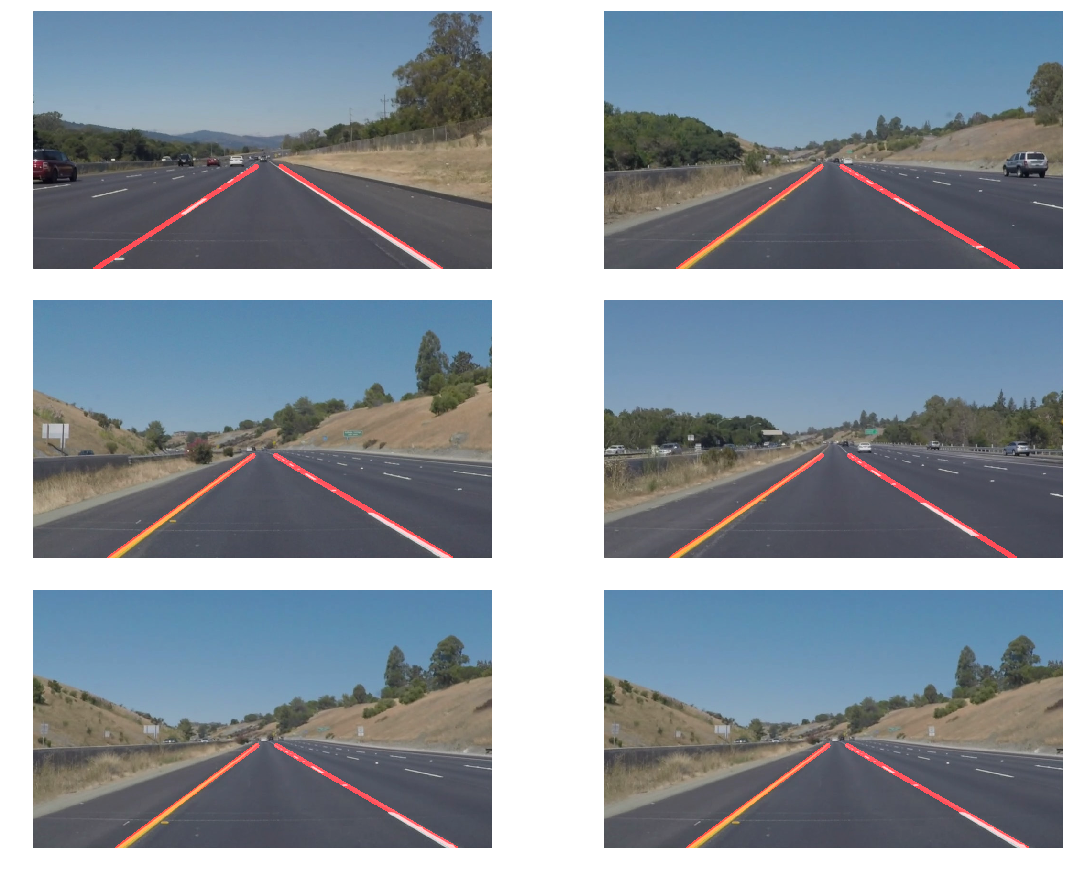

In [3]:
import glob

fig = plt.figure(figsize=(16, 16))

for i, fn in enumerate(glob.glob('test_images/*.jpg')):
    original_image = mpimg.imread(fn)
    processor = LaneLineDetector(original_image)
    img = processor.process()
    
    plt.subplot(4, 2, i+1)
    plt.imshow(img)
    plt.axis("off")
    
fig.tight_layout()

[MoviePy] >>>> Building video white-output.mp4
[MoviePy] Writing video white-output.mp4


100%|█████████▉| 221/222 [00:07<00:00, 31.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white-output.mp4 

CPU times: user 6.6 s, sys: 370 ms, total: 6.97 s
Wall time: 7.51 s


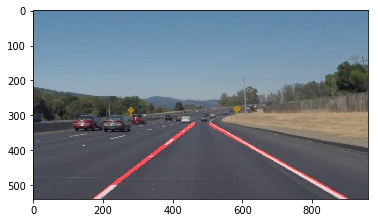

In [4]:
from urllib.request import urlretrieve

if not os.path.isfile('solidWhiteRight.mp4'):
    urlretrieve('http://brianz-udacity-sdc.s3.amazonaws.com/p1/solidWhiteRight.mp4', 'solidWhiteRight.mp4')

white_output = 'white-output.mp4'
video_clip = VideoFileClip("solidWhiteRight.mp4")
processor = LaneLineDetector()
white_clip = video_clip.fl_image(processor.process_clip)
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [5]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[MoviePy] >>>> Building video yellow-output.mp4
[MoviePy] Writing video yellow-output.mp4


100%|█████████▉| 681/682 [00:21<00:00, 31.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow-output.mp4 

CPU times: user 20.5 s, sys: 1.27 s, total: 21.7 s
Wall time: 22.2 s


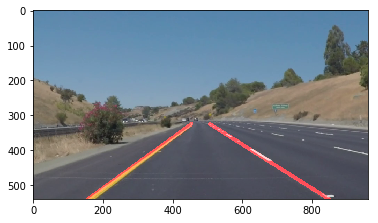

In [6]:
if not os.path.isfile('solidYellowLeft.mp4'):
    urlretrieve('http://brianz-udacity-sdc.s3.amazonaws.com/p1/solidYellowLeft.mp4', 'solidYellowLeft.mp4')

yellow_output = 'yellow-output.mp4'
video_clip = VideoFileClip("solidYellowLeft.mp4")
processor = LaneLineDetector()
yellow_clip = video_clip.fl_image(processor.process_clip)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Thoughts on solution

I can see some shortcomings when there are straight lines detected near the lane lines which have the same slope.
In my solution I assume that any line within my bounding box with an expected slope is part of the lane line. 
I then set the outer and inner x coordinates to those which are furthest to the left or right 
(for a given line, left or right). However, if there are other lines detected outside of the lanes that hurestic won't
work.

Additionally, while changing lanes this algorithm would likely fail as the lanes would show up in unexpected places
whithin the frame.  This solution expects a left and right lane with a postivite or negative slope within a given
region. When changing lanes the camera would likely pick up the lanes with unexpected slopes that could confuse
the algorithm.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))